# MIMIC-III: Concept-Drift and EHR for Neural Networks

The MIMIC-III database has been gathered between 2001 and 2012 at the Beth Israel Deaconess Medical Center. In 2008, the hospital switched the its electronic health records (EHR) devices from the Carevue to Metavision system. This change reflects a more general phenomenon: the constant update and morphing of care practices, which is reflected on the database as concept drift.

This notebook will investigate the effect of this specific change in care practices on the predictive power of the models from the MIMIC-III benchmark. Note, this notebook will treat dnn methods, while another notebook was setup to treat linear methods. To do so, we will split the data by chartevents generated by the carevue and metavision system.

We will begin by training the benchmark models with randomly picked subject and subsequently apply our split. We will evaluate the effect on the metrics of the models and additionally analysze the change in calibration charcteristics for deep learning models.

In [1]:
import pdb
import os
import json
import numpy as np
from pathlib import Path
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC
from utils.mimic import get_sample_size

import datasets.mimic
from preprocessing.mimic import Preprocessor
from preprocessing import Discretizer, BatchGenerator, Normalizer
from models.lstm import LSTMNetwork
from utils.IO import *
import pipeline.mimic as pipeline

2022-08-01 07:13:29.547293: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-01 07:13:32.704457: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-08-01 07:13:32.704557: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 70d565007eee
2022-08-01 07:13:32.704569: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 70d565007eee
2022-08-01 07:13:32.704803: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.48.7
2022-08-01 07:13:32.705244: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.48.7
2022-08-01 07:13:32.705255: I tensorflow/stream_executor/cu

## Running the Benchmark Models

The phenotyping task needs the full dataset to make valid predictions, therefore we do not recomend using it here.

### Load and Prepare the Data
Next we load and preprocess the data for a given set into sample, label pairs which can directly be fed to the batch generator.

In [2]:
model_config = {
    "layer_size": 128,
    "input_dim": 59,
    "depth": 1,
    "dropout_rate": 0,
    "task": "decompensation"
}

pipeline_config = {
    "model_name": "lstm_concept_drit_bm",
    "batch_size": 8,
    "epochs": 5,
    "test_fraction_split": 0.49,
    "task": "decompensation",
    "output_type": "one-hot",
    "compiler_config" : {
        "optimizer": "adam",
        "metrics": [
            AUC(curve='ROC'), 
            AUC(curve='PR')
        ],
        "loss": "binary_crossentropy",
        "run_eagerly": True
    }
}

2022-08-01 07:13:33.507009: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
(timeseries,
 episodic_data,
 subject_events,
 subject_diagnoses,
 subject_icu_history) = datasets.mimic.load_data(path=Path(os.getenv("DATA"), "mimic-iii-demo"))

INFO - 2022-08-01 07:13:33:datasets/mimic.py:L 51 - task data


INFO - 2022-08-01 07:13:43:pipeline/mimic.py:L 104 - Splitting Dataset.
INFO - 2022-08-01 07:13:43:pipeline/mimic.py:L 141 - Preprocessing data.
INFO - 2022-08-01 07:13:43:preprocessing/mimic.py:L 60 - Only type available for this task is binary! Argument disregarded
INFO - 2022-08-01 07:13:44:pipeline/mimic.py:L 156 - Done.
INFO - 2022-08-01 07:13:44:pipeline/mimic.py:L 115 - Done.
INFO - 2022-08-01 07:13:44:pipeline/mimic.py:L 121 - Starting model run for model: lstm_concept_drit_bm!
INFO - 2022-08-01 07:13:47:preprocessing/__init__.py:L 464 - Done computing new normalizer in 2.478175640106201!
Model: "lstm_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, None, 59)]        0         
                                                                 
 masking (Masking)           (None, None, 59)          0         
                                            

2022-08-01 07:13:48.200607: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-08-01 07:13:48.227217: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-08-01 07:13:49.000434: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-08-01 07:13:49.013740: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-08-01 07:13:50.610242: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_sh

INFO - 2022-08-01 07:13:53:pipeline/mimic.py:L 273 - Evaluating model.
652/652 [==============================] - 311s 477ms/step - loss: 0.1250 - auc: 0.9087 - auc_1: 0.4388
INFO - 2022-08-01 07:19:05:pipeline/mimic.py:L 280 - Evaluation complete.


[0.12497211247682571, 0.9087468385696411, 0.4387904703617096]

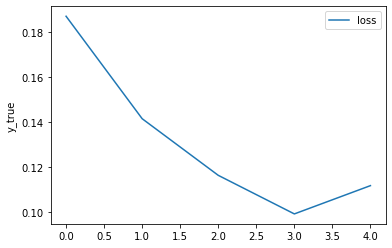

In [4]:
model = LSTMNetwork(**model_config)
pipe = pipeline.MIMICPipeline(model, **pipeline_config)
model, history = pipe.fit(timeseries,
                          episodic_data,
                          subject_diagnoses,
                          subject_icu_history)
pipe.score()

# Creating Concept Drift
Now that we have our benchmark model ready, we can begin by investigating the concept drift, which is induced through the EHR switch. The first concern to make sure that the comparision is valid is to deduce the test set size and retrospectively align it for our benchmark. To do so, we will count the number of total available samples for the carevue system.

We can load the carevue-only timeseries data by specifying the 'ehr' parameter with our load_data function. For subsequent variables, we will use the mv suffix for metavision samples and the cv suffix for carevue samples.

### Preparing Data Split

In [5]:
model_config = {
    "layer_size": 128,
    "input_dim": 59,
    "depth": 1,
    "dropout_rate": 0,
    "task": "decompensation"
}

pipeline_config = {
    "model_name": "lstm_concept_drift_ehr",
    "batch_size": 8,
    "epochs": 5,
    "test_fraction_split": 0,
    "task": "decompensation",
    "output_type": "one-hot",
    "compiler_config" : {
        "optimizer": "adam",
        "metrics": [
            AUC(curve='ROC'), 
            AUC(curve='PR')
        ],
        "loss": "binary_crossentropy",
        "run_eagerly": True
    }
}

In [6]:
(timeseries_cv,
 episodic_data_cv,
 subject_events_cv,
 subject_diagnoses_cv,
 subject_icu_history_cv) = datasets.mimic.load_data(path=Path(os.getenv("DATA"), "mimic-iii-demo"),
                                                    ehr='carevue')

INFO - 2022-08-01 07:19:05:datasets/mimic.py:L 51 - task data


In [7]:
(timeseries_mv,
 episodic_data_mv,
 subject_events_mv,
 subject_diagnoses_mv,
 subject_icu_history_mv) = datasets.mimic.load_data(path=Path(os.getenv("DATA"), "mimic-iii-demo"),
                                                    ehr="metavision")

INFO - 2022-08-01 07:19:09:datasets/mimic.py:L 51 - task data


In [8]:
model = LSTMNetwork(**model_config)
from importlib import reload
reload(pipeline)
pipe = pipeline.MIMICPipeline(model, **pipeline_config)
model, history = pipe.fit(timeseries_cv,
                          episodic_data_cv,
                          subject_diagnoses_cv,
                          subject_icu_history_cv)


INFO - 2022-08-01 07:19:13:pipeline/mimic.py:L 104 - Splitting Dataset.
INFO - 2022-08-01 07:19:13:pipeline/mimic.py:L 141 - Preprocessing data.
INFO - 2022-08-01 07:19:13:preprocessing/mimic.py:L 60 - Only type available for this task is binary! Argument disregarded
INFO - 2022-08-01 07:19:14:pipeline/mimic.py:L 156 - Done.
INFO - 2022-08-01 07:19:14:pipeline/mimic.py:L 115 - Done.
INFO - 2022-08-01 07:19:14:pipeline/mimic.py:L 121 - Starting model run for model: lstm_concept_drift_ehr!
INFO - 2022-08-01 07:19:14:preprocessing/__init__.py:L 464 - Done computing new normalizer in 0.6267867088317871!
Model: "lstm_network_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, None, 59)]        0         
                                                                 
 masking_1 (Masking)         (None, None, 59)          0         
                                       

2022-08-01 07:19:16.037447: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-08-01 07:19:16.222225: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-08-01 07:19:16.231934: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-08-01 07:19:16.242562: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-08-01 07:19:16.367299: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_sh

INFO - 2022-08-01 07:19:17:pipeline/mimic.py:L 141 - Preprocessing data.
INFO - 2022-08-01 07:19:17:preprocessing/mimic.py:L 60 - Only type available for this task is binary! Argument disregarded
INFO - 2022-08-01 07:19:17:pipeline/mimic.py:L 156 - Done.
INFO - 2022-08-01 07:19:17:pipeline/mimic.py:L 273 - Evaluating model.
631/631 [==============================] - 155s 245ms/step - loss: 0.2847 - auc_2: 0.5637 - auc_3: 0.0271
INFO - 2022-08-01 07:21:52:pipeline/mimic.py:L 280 - Evaluation complete.


[0.28474223613739014, 0.5637025833129883, 0.027103759348392487]

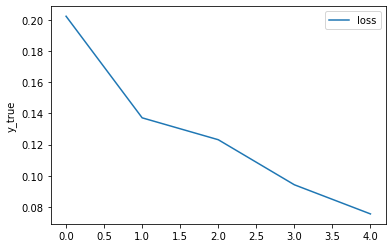

In [9]:
X_subjects, y_subjects = pipe.process(timeseries_mv,
                                      episodic_data_mv,
                                      subject_diagnoses_mv,
                                      subject_icu_history_mv)

X_test = [*X_subjects.values()]
y_test = [*y_subjects.values()]

test_generator = pipe.make_generator(X_test, y_test)
pipe.score(test_generator)

### Setting up the Model Run

In [10]:
test_size = get_sample_size(X_subjects_mv) / (get_sample_size(X_subjects_mv) +  get_sample_size(X_subjects_cv))
test_size

NameError: name 'X_subjects_mv' is not defined